# Import Datasets(dog & human)

In [2]:
from sklearn.datasets import load_files
from keras.utils import np_utils
import numpy as np
from glob import glob

def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']) , 133)
    return dog_files , dog_targets

train_files , train_targets = load_dataset('dogImages/train')
valid_files , valid_targets = load_dataset('dogImages/valid')
test_files , test_targets = load_dataset('dogImages/test')

dog_names = [item[20:-1] for item in sorted(glob("dogImages/train/*/"))]

print('there are %d total dog categories'% len(dog_names))
print('there are %s total dog images\n' %len(np.hstack([train_files , valid_files , test_files])))
print('there are %d training dog images' %len(train_files))
print('there are %d validation dog images' %len(valid_files))
print('there are %d testing dog images' %len(test_files))

Using TensorFlow backend.


there are 133 total dog categories
there are 8351 total dog images

there are 6680 training dog images
there are 835 validation dog images
there are 836 testing dog images


In [3]:
import random
random.seed(8675309)

human_files = np.array(glob("lfw/*/*"))
random.shuffle(human_files)

print('there are %d total human images' %len(human_files))

there are 13233 total human images


# Detect humans

number of faces detected: 2


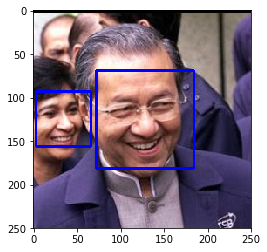

In [4]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

img = cv2.imread(human_files[14])
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

faces = face_cascade.detectMultiScale(gray)

print('number of faces detected:', len(faces))

for (x , y , w , h) in faces:
    cv2.rectangle(img , (x , y) , (x + w , y + h) , (255 , 0 , 0) , 2)
    
cv_rgb = cv2.cvtColor(img , cv2.COLOR_BGR2RGB)

plt.imshow(cv_rgb)
plt.show()

### Human Face Dectector :--

In [5]:
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img , cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

In [6]:
human_files_short = human_files[:100]
dog_files_short = train_files[:100]
y = 0
z = 0

for i in range(len(human_files_short)):
    x = face_detector(human_files_short[i])
    if (x!=0):
        y = y+1

for i in range(len(dog_files_short)):
    x = face_detector(dog_files_short[i])
    if (x!=0):
        z = z+1
print('%d percentage of human images were with a detected human face' % (y))
print('%d percentage of dog images were with a detected human face' % (z))

99 percentage of human images were with a detected human face
12 percentage of dog images were with a detected human face


# Detect dogs

In [7]:
from keras.applications.resnet50 import ResNet50

ResNet50_model = ResNet50(weights = 'imagenet')

Instructions for updating:
Colocations handled automatically by placer.


### Preprocess the data :--

In [8]:
from keras.preprocessing import image
from tqdm import tqdm

def path_to_tensor(img_path):
    img = image.load_img(img_path , target_size = (224 , 224))
    x = image.img_to_array(img)
    return np.expand_dims(x , axis = 0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

### Making predictions :--

In [9]:
from keras.applications.resnet50 import preprocess_input , decode_predictions

def ResNet50_predict_labels(img_path):
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))

### Dog Detector

In [10]:
def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return((prediction <= 268) & (prediction >= 151))

In [11]:
y = 0
z = 0

for i in range(len(human_files_short)):
    x = dog_detector(human_files_short[i])
    if (x == True):
        y = y+1

for i in range(len(dog_files_short)):
    x = dog_detector(dog_files_short[i])
    if (x == True):
        z = z+1
print('%d percentage of human images were with a detected human face' % (y))
print('%d percentage of dog images were with a detected human face' % (z))

1 percentage of human images were with a detected human face
100 percentage of dog images were with a detected human face


In [12]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|████████████████████████████████████████████████████████████████████████████████| 836/836 [00:12<00:00, 64.76it/s]


# Model Architecture

In [13]:
from keras.layers import Conv2D , MaxPooling2D , GlobalAveragePooling2D
from keras.layers import Dropout , Flatten , Dense
from keras.models import Sequential

model = Sequential()
model.add(Conv2D(filters = 16 , kernel_size = 2 , padding = 'same' , activation = 'relu' , input_shape = (224 , 224 , 3)))
model.add(MaxPooling2D(pool_size = 2))
model.add(Conv2D(filters = 32 , kernel_size = 2 , padding = 'same' , activation = 'relu'))
model.add(MaxPooling2D(pool_size = 2))
model.add(Conv2D(filters = 64 , kernel_size = 2 , padding = 'same' , activation = 'relu'))
model.add(MaxPooling2D(pool_size = 2))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(512 , activation = 'relu'))
model.add(Dropout(0.4))
model.add(Dense(133 , activation = 'softmax'))
model.summary()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 16)      208       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 32)      2080      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 56, 56, 64)        8256      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 28, 28, 64)        0         
___________________________

# Compile the model

In [14]:
model.compile(optimizer = 'rmsprop' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])


# Train the model

In [ ]:
from keras.callbacks import ModelCheckpoint  

epochs = 25

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5' , verbose=1, save_best_only=True)

model.fit(train_tensors, train_targets , validation_data=(valid_tensors, valid_targets) , epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=1)

Instructions for updating:
Use tf.cast instead.
Train on 6680 samples, validate on 835 samples
Epoch 1/25


4060/6680 [=================>............] - ETA: 3:56:21 - loss: 4.8937 - acc: 0.0000e+ - ETA: 1:59:53 - loss: 8.8356 - acc: 0.0000e+ - ETA: 1:21:12 - loss: 8.6797 - acc: 0.0000e+ - ETA: 1:01:37 - loss: 7.9122 - acc: 0.0000e+ - ETA: 49:56 - loss: 7.2981 - acc: 0.0100     - ETA: 42:07 - loss: 7.0089 - acc: 0.00 - ETA: 36:29 - loss: 6.7340 - acc: 0.00 - ETA: 32:19 - loss: 6.5352 - acc: 0.00 - ETA: 29:02 - loss: 6.3503 - acc: 0.00 - ETA: 26:26 - loss: 6.2136 - acc: 0.00 - ETA: 24:17 - loss: 6.0970 - acc: 0.00 - ETA: 22:30 - loss: 6.0006 - acc: 0.00 - ETA: 20:59 - loss: 5.9212 - acc: 0.00 - ETA: 19:42 - loss: 5.8564 - acc: 0.00 - ETA: 18:36 - loss: 5.7925 - acc: 0.00 - ETA: 17:37 - loss: 5.7363 - acc: 0.00 - ETA: 16:45 - loss: 5.6856 - acc: 0.00 - ETA: 16:00 - loss: 5.6429 - acc: 0.00 - ETA: 15:19 - loss: 5.6005 - acc: 0.00 - ETA: 14:40 - loss: 5.5654 - acc: 0.00 - ETA: 14:37 - loss: 5.5345 - acc: 0.00 - ETA: 14:43 - loss: 5.5057 - acc: 0.00 - ETA: 14:15 - loss: 5.4791 - acc: 0.01 - ETA: 

6680/6680 [==============================] - ETA: 2:15 - loss: 4.9539 - acc: 0.013 - ETA: 2:13 - loss: 4.9535 - acc: 0.013 - ETA: 2:12 - loss: 4.9531 - acc: 0.013 - ETA: 2:11 - loss: 4.9523 - acc: 0.013 - ETA: 2:10 - loss: 4.9519 - acc: 0.013 - ETA: 2:09 - loss: 4.9512 - acc: 0.013 - ETA: 2:07 - loss: 4.9511 - acc: 0.013 - ETA: 2:06 - loss: 4.9506 - acc: 0.013 - ETA: 2:05 - loss: 4.9502 - acc: 0.013 - ETA: 2:04 - loss: 4.9494 - acc: 0.013 - ETA: 2:03 - loss: 4.9484 - acc: 0.013 - ETA: 2:01 - loss: 4.9481 - acc: 0.013 - ETA: 2:00 - loss: 4.9479 - acc: 0.013 - ETA: 1:59 - loss: 4.9473 - acc: 0.013 - ETA: 1:58 - loss: 4.9467 - acc: 0.013 - ETA: 1:57 - loss: 4.9460 - acc: 0.013 - ETA: 1:56 - loss: 4.9454 - acc: 0.013 - ETA: 1:54 - loss: 4.9448 - acc: 0.013 - ETA: 1:53 - loss: 4.9446 - acc: 0.013 - ETA: 1:52 - loss: 4.9439 - acc: 0.013 - ETA: 1:51 - loss: 4.9433 - acc: 0.013 - ETA: 1:50 - loss: 4.9421 - acc: 0.013 - ETA: 1:49 - loss: 4.9409 - acc: 0.013 - ETA: 1:47 - loss: 4.9393 - acc: 0.0

4080/6680 [=================>............] - ETA: 3:58 - loss: 4.4788 - acc: 0.0000e+0 - ETA: 3:56 - loss: 4.4455 - acc: 0.0500    - ETA: 7:18 - loss: 4.5039 - acc: 0.033 - ETA: 9:39 - loss: 4.5016 - acc: 0.025 - ETA: 8:37 - loss: 4.5210 - acc: 0.020 - ETA: 7:54 - loss: 4.5333 - acc: 0.016 - ETA: 7:22 - loss: 4.5451 - acc: 0.021 - ETA: 6:57 - loss: 4.5144 - acc: 0.037 - ETA: 6:37 - loss: 4.5253 - acc: 0.044 - ETA: 6:21 - loss: 4.5349 - acc: 0.045 - ETA: 7:12 - loss: 4.5420 - acc: 0.059 - ETA: 7:44 - loss: 4.5472 - acc: 0.054 - ETA: 7:26 - loss: 4.5270 - acc: 0.053 - ETA: 7:11 - loss: 4.5348 - acc: 0.050 - ETA: 6:57 - loss: 4.5280 - acc: 0.046 - ETA: 6:46 - loss: 4.5312 - acc: 0.043 - ETA: 6:35 - loss: 4.5267 - acc: 0.044 - ETA: 6:25 - loss: 4.5292 - acc: 0.044 - ETA: 6:42 - loss: 4.5369 - acc: 0.042 - ETA: 7:13 - loss: 4.5447 - acc: 0.040 - ETA: 7:04 - loss: 4.5441 - acc: 0.040 - ETA: 6:55 - loss: 4.5569 - acc: 0.038 - ETA: 6:46 - loss: 4.5526 - acc: 0.041 - ETA: 6:38 - loss: 4.5405 - 

6680/6680 [==============================] - ETA: 2:06 - loss: 4.4571 - acc: 0.050 - ETA: 2:05 - loss: 4.4560 - acc: 0.050 - ETA: 2:03 - loss: 4.4558 - acc: 0.050 - ETA: 2:02 - loss: 4.4576 - acc: 0.050 - ETA: 2:01 - loss: 4.4563 - acc: 0.050 - ETA: 2:00 - loss: 4.4570 - acc: 0.050 - ETA: 1:59 - loss: 4.4565 - acc: 0.051 - ETA: 1:58 - loss: 4.4546 - acc: 0.051 - ETA: 1:58 - loss: 4.4548 - acc: 0.051 - ETA: 1:58 - loss: 4.4537 - acc: 0.051 - ETA: 1:57 - loss: 4.4533 - acc: 0.051 - ETA: 1:56 - loss: 4.4532 - acc: 0.051 - ETA: 1:55 - loss: 4.4530 - acc: 0.051 - ETA: 1:54 - loss: 4.4514 - acc: 0.051 - ETA: 1:53 - loss: 4.4513 - acc: 0.051 - ETA: 1:52 - loss: 4.4502 - acc: 0.051 - ETA: 1:51 - loss: 4.4501 - acc: 0.051 - ETA: 1:49 - loss: 4.4478 - acc: 0.052 - ETA: 1:48 - loss: 4.4479 - acc: 0.051 - ETA: 1:47 - loss: 4.4486 - acc: 0.051 - ETA: 1:46 - loss: 4.4487 - acc: 0.051 - ETA: 1:45 - loss: 4.4493 - acc: 0.051 - ETA: 1:44 - loss: 4.4481 - acc: 0.052 - ETA: 1:43 - loss: 4.4476 - acc: 0.0

4080/6680 [=================>............] - ETA: 4:32 - loss: 4.3850 - acc: 0.050 - ETA: 4:30 - loss: 4.0450 - acc: 0.175 - ETA: 4:27 - loss: 4.0790 - acc: 0.150 - ETA: 4:24 - loss: 3.9847 - acc: 0.162 - ETA: 4:25 - loss: 4.0803 - acc: 0.130 - ETA: 4:21 - loss: 4.0808 - acc: 0.133 - ETA: 4:19 - loss: 4.1042 - acc: 0.128 - ETA: 4:17 - loss: 4.1163 - acc: 0.118 - ETA: 4:16 - loss: 4.1626 - acc: 0.105 - ETA: 4:16 - loss: 4.1608 - acc: 0.110 - ETA: 4:15 - loss: 4.1370 - acc: 0.113 - ETA: 4:15 - loss: 4.1263 - acc: 0.116 - ETA: 4:15 - loss: 4.1032 - acc: 0.111 - ETA: 4:12 - loss: 4.1267 - acc: 0.103 - ETA: 4:11 - loss: 4.1244 - acc: 0.103 - ETA: 4:09 - loss: 4.1427 - acc: 0.100 - ETA: 4:08 - loss: 4.1266 - acc: 0.100 - ETA: 4:07 - loss: 4.1100 - acc: 0.100 - ETA: 4:08 - loss: 4.1168 - acc: 0.097 - ETA: 4:06 - loss: 4.1029 - acc: 0.102 - ETA: 4:05 - loss: 4.0947 - acc: 0.100 - ETA: 4:04 - loss: 4.0883 - acc: 0.100 - ETA: 4:03 - loss: 4.0869 - acc: 0.095 - ETA: 4:03 - loss: 4.0851 - acc: 0.0

6680/6680 [==============================] - ETA: 1:51 - loss: 4.0538 - acc: 0.094 - ETA: 1:51 - loss: 4.0542 - acc: 0.094 - ETA: 1:50 - loss: 4.0539 - acc: 0.094 - ETA: 1:49 - loss: 4.0536 - acc: 0.094 - ETA: 1:48 - loss: 4.0525 - acc: 0.094 - ETA: 1:47 - loss: 4.0519 - acc: 0.095 - ETA: 1:47 - loss: 4.0519 - acc: 0.095 - ETA: 1:47 - loss: 4.0519 - acc: 0.095 - ETA: 1:46 - loss: 4.0521 - acc: 0.095 - ETA: 1:45 - loss: 4.0490 - acc: 0.096 - ETA: 1:45 - loss: 4.0498 - acc: 0.096 - ETA: 1:44 - loss: 4.0486 - acc: 0.095 - ETA: 1:43 - loss: 4.0461 - acc: 0.096 - ETA: 1:42 - loss: 4.0474 - acc: 0.096 - ETA: 1:41 - loss: 4.0489 - acc: 0.096 - ETA: 1:40 - loss: 4.0478 - acc: 0.096 - ETA: 1:40 - loss: 4.0456 - acc: 0.096 - ETA: 1:40 - loss: 4.0444 - acc: 0.096 - ETA: 1:39 - loss: 4.0462 - acc: 0.095 - ETA: 1:38 - loss: 4.0453 - acc: 0.095 - ETA: 1:37 - loss: 4.0437 - acc: 0.095 - ETA: 1:36 - loss: 4.0449 - acc: 0.095 - ETA: 1:35 - loss: 4.0461 - acc: 0.095 - ETA: 1:34 - loss: 4.0454 - acc: 0.0

4080/6680 [=================>............] - ETA: 4:07 - loss: 3.7947 - acc: 0.150 - ETA: 4:06 - loss: 3.5514 - acc: 0.125 - ETA: 4:07 - loss: 3.4934 - acc: 0.150 - ETA: 4:09 - loss: 3.5511 - acc: 0.150 - ETA: 6:31 - loss: 3.7384 - acc: 0.140 - ETA: 8:06 - loss: 3.6799 - acc: 0.150 - ETA: 7:33 - loss: 3.6753 - acc: 0.135 - ETA: 7:07 - loss: 3.6647 - acc: 0.156 - ETA: 6:47 - loss: 3.6480 - acc: 0.144 - ETA: 6:32 - loss: 3.6521 - acc: 0.140 - ETA: 6:18 - loss: 3.6706 - acc: 0.131 - ETA: 6:06 - loss: 3.6827 - acc: 0.133 - ETA: 5:55 - loss: 3.6765 - acc: 0.138 - ETA: 5:45 - loss: 3.6602 - acc: 0.139 - ETA: 5:39 - loss: 3.6442 - acc: 0.146 - ETA: 5:31 - loss: 3.6694 - acc: 0.143 - ETA: 5:25 - loss: 3.6563 - acc: 0.147 - ETA: 5:19 - loss: 3.6196 - acc: 0.150 - ETA: 5:18 - loss: 3.6197 - acc: 0.147 - ETA: 5:12 - loss: 3.6473 - acc: 0.142 - ETA: 5:08 - loss: 3.6621 - acc: 0.142 - ETA: 5:03 - loss: 3.6566 - acc: 0.143 - ETA: 4:59 - loss: 3.6680 - acc: 0.141 - ETA: 4:55 - loss: 3.6628 - acc: 0.1

6680/6680 [==============================] - ETA: 2:12 - loss: 3.5390 - acc: 0.176 - ETA: 2:11 - loss: 3.5402 - acc: 0.176 - ETA: 2:09 - loss: 3.5395 - acc: 0.176 - ETA: 2:08 - loss: 3.5376 - acc: 0.176 - ETA: 2:07 - loss: 3.5354 - acc: 0.176 - ETA: 2:06 - loss: 3.5311 - acc: 0.177 - ETA: 2:05 - loss: 3.5323 - acc: 0.177 - ETA: 2:04 - loss: 3.5324 - acc: 0.177 - ETA: 2:02 - loss: 3.5328 - acc: 0.177 - ETA: 2:01 - loss: 3.5349 - acc: 0.176 - ETA: 2:00 - loss: 3.5352 - acc: 0.177 - ETA: 1:59 - loss: 3.5316 - acc: 0.177 - ETA: 1:58 - loss: 3.5348 - acc: 0.177 - ETA: 1:57 - loss: 3.5358 - acc: 0.177 - ETA: 1:56 - loss: 3.5346 - acc: 0.178 - ETA: 1:54 - loss: 3.5348 - acc: 0.178 - ETA: 1:53 - loss: 3.5358 - acc: 0.177 - ETA: 1:52 - loss: 3.5373 - acc: 0.177 - ETA: 1:51 - loss: 3.5368 - acc: 0.177 - ETA: 1:50 - loss: 3.5393 - acc: 0.177 - ETA: 1:49 - loss: 3.5382 - acc: 0.177 - ETA: 1:48 - loss: 3.5384 - acc: 0.177 - ETA: 1:46 - loss: 3.5370 - acc: 0.178 - ETA: 1:45 - loss: 3.5383 - acc: 0.1

4080/6680 [=================>............] - ETA: 4:07 - loss: 3.0735 - acc: 0.350 - ETA: 7:49 - loss: 3.0221 - acc: 0.375 - ETA: 11:36 - loss: 2.9597 - acc: 0.36 - ETA: 9:46 - loss: 2.8985 - acc: 0.3375 - ETA: 8:43 - loss: 2.8499 - acc: 0.360 - ETA: 7:59 - loss: 2.9682 - acc: 0.316 - ETA: 7:27 - loss: 3.0728 - acc: 0.292 - ETA: 7:03 - loss: 3.0390 - acc: 0.293 - ETA: 6:42 - loss: 3.0809 - acc: 0.283 - ETA: 6:24 - loss: 3.0511 - acc: 0.295 - ETA: 6:10 - loss: 3.0693 - acc: 0.286 - ETA: 6:48 - loss: 3.0229 - acc: 0.295 - ETA: 7:26 - loss: 3.0248 - acc: 0.284 - ETA: 7:11 - loss: 3.0642 - acc: 0.282 - ETA: 6:58 - loss: 3.0231 - acc: 0.290 - ETA: 6:46 - loss: 3.0125 - acc: 0.293 - ETA: 6:35 - loss: 2.9584 - acc: 0.297 - ETA: 6:26 - loss: 2.9847 - acc: 0.286 - ETA: 6:33 - loss: 2.9921 - acc: 0.289 - ETA: 7:04 - loss: 2.9880 - acc: 0.290 - ETA: 7:00 - loss: 2.9999 - acc: 0.288 - ETA: 6:51 - loss: 3.0021 - acc: 0.286 - ETA: 6:43 - loss: 2.9845 - acc: 0.291 - ETA: 6:35 - loss: 2.9819 - acc: 0.

6680/6680 [==============================] - ETA: 2:08 - loss: 2.8518 - acc: 0.311 - ETA: 2:07 - loss: 2.8512 - acc: 0.311 - ETA: 2:07 - loss: 2.8526 - acc: 0.310 - ETA: 2:07 - loss: 2.8532 - acc: 0.311 - ETA: 2:06 - loss: 2.8529 - acc: 0.311 - ETA: 2:05 - loss: 2.8509 - acc: 0.311 - ETA: 2:04 - loss: 2.8519 - acc: 0.311 - ETA: 2:03 - loss: 2.8546 - acc: 0.310 - ETA: 2:02 - loss: 2.8530 - acc: 0.310 - ETA: 2:00 - loss: 2.8517 - acc: 0.311 - ETA: 2:00 - loss: 2.8525 - acc: 0.311 - ETA: 2:00 - loss: 2.8540 - acc: 0.310 - ETA: 1:59 - loss: 2.8574 - acc: 0.310 - ETA: 1:58 - loss: 2.8600 - acc: 0.309 - ETA: 1:57 - loss: 2.8614 - acc: 0.308 - ETA: 1:56 - loss: 2.8598 - acc: 0.309 - ETA: 1:55 - loss: 2.8606 - acc: 0.308 - ETA: 1:53 - loss: 2.8611 - acc: 0.308 - ETA: 1:52 - loss: 2.8565 - acc: 0.310 - ETA: 1:52 - loss: 2.8553 - acc: 0.310 - ETA: 1:52 - loss: 2.8613 - acc: 0.308 - ETA: 1:51 - loss: 2.8600 - acc: 0.309 - ETA: 1:50 - loss: 2.8602 - acc: 0.309 - ETA: 1:48 - loss: 2.8632 - acc: 0.3

4080/6680 [=================>............] - ETA: 14:14 - loss: 2.2890 - acc: 0.45 - ETA: 14:45 - loss: 2.0297 - acc: 0.52 - ETA: 11:18 - loss: 2.0716 - acc: 0.50 - ETA: 9:31 - loss: 2.1085 - acc: 0.5250 - ETA: 8:26 - loss: 2.0476 - acc: 0.540 - ETA: 7:50 - loss: 2.0486 - acc: 0.533 - ETA: 7:17 - loss: 2.1147 - acc: 0.514 - ETA: 6:52 - loss: 2.0256 - acc: 0.525 - ETA: 6:33 - loss: 2.1533 - acc: 0.488 - ETA: 6:15 - loss: 2.1328 - acc: 0.490 - ETA: 7:09 - loss: 2.1460 - acc: 0.490 - ETA: 7:39 - loss: 2.1756 - acc: 0.479 - ETA: 7:22 - loss: 2.2068 - acc: 0.469 - ETA: 7:07 - loss: 2.1404 - acc: 0.482 - ETA: 6:55 - loss: 2.1614 - acc: 0.480 - ETA: 6:44 - loss: 2.1805 - acc: 0.475 - ETA: 6:33 - loss: 2.1531 - acc: 0.482 - ETA: 6:23 - loss: 2.1412 - acc: 0.483 - ETA: 6:13 - loss: 2.1259 - acc: 0.484 - ETA: 6:35 - loss: 2.1321 - acc: 0.487 - ETA: 6:56 - loss: 2.0917 - acc: 0.495 - ETA: 6:47 - loss: 2.0965 - acc: 0.493 - ETA: 6:39 - loss: 2.1336 - acc: 0.487 - ETA: 6:32 - loss: 2.1228 - acc: 0.

6680/6680 [==============================] - ETA: 2:22 - loss: 2.0176 - acc: 0.496 - ETA: 2:21 - loss: 2.0177 - acc: 0.495 - ETA: 2:20 - loss: 2.0152 - acc: 0.496 - ETA: 2:18 - loss: 2.0139 - acc: 0.496 - ETA: 2:17 - loss: 2.0151 - acc: 0.496 - ETA: 2:16 - loss: 2.0180 - acc: 0.496 - ETA: 2:15 - loss: 2.0177 - acc: 0.496 - ETA: 2:15 - loss: 2.0167 - acc: 0.495 - ETA: 2:14 - loss: 2.0201 - acc: 0.494 - ETA: 2:13 - loss: 2.0196 - acc: 0.494 - ETA: 2:12 - loss: 2.0196 - acc: 0.494 - ETA: 2:10 - loss: 2.0204 - acc: 0.493 - ETA: 2:09 - loss: 2.0185 - acc: 0.494 - ETA: 2:08 - loss: 2.0149 - acc: 0.495 - ETA: 2:07 - loss: 2.0152 - acc: 0.495 - ETA: 2:06 - loss: 2.0175 - acc: 0.494 - ETA: 2:06 - loss: 2.0164 - acc: 0.494 - ETA: 2:05 - loss: 2.0162 - acc: 0.495 - ETA: 2:03 - loss: 2.0140 - acc: 0.495 - ETA: 2:02 - loss: 2.0157 - acc: 0.496 - ETA: 2:01 - loss: 2.0147 - acc: 0.495 - ETA: 2:00 - loss: 2.0117 - acc: 0.496 - ETA: 1:58 - loss: 2.0120 - acc: 0.496 - ETA: 1:57 - loss: 2.0128 - acc: 0.4

4080/6680 [=================>............] - ETA: 5:10 - loss: 1.0506 - acc: 0.750 - ETA: 5:03 - loss: 1.3686 - acc: 0.650 - ETA: 5:03 - loss: 1.3056 - acc: 0.666 - ETA: 4:52 - loss: 1.2072 - acc: 0.700 - ETA: 4:46 - loss: 1.1902 - acc: 0.700 - ETA: 4:41 - loss: 1.2848 - acc: 0.650 - ETA: 4:39 - loss: 1.3663 - acc: 0.635 - ETA: 4:36 - loss: 1.3685 - acc: 0.643 - ETA: 4:37 - loss: 1.3293 - acc: 0.650 - ETA: 4:35 - loss: 1.2660 - acc: 0.675 - ETA: 4:33 - loss: 1.2532 - acc: 0.677 - ETA: 4:31 - loss: 1.2298 - acc: 0.675 - ETA: 4:29 - loss: 1.2517 - acc: 0.669 - ETA: 4:30 - loss: 1.2366 - acc: 0.675 - ETA: 4:28 - loss: 1.2905 - acc: 0.670 - ETA: 4:27 - loss: 1.2883 - acc: 0.675 - ETA: 4:25 - loss: 1.2739 - acc: 0.676 - ETA: 4:25 - loss: 1.2810 - acc: 0.672 - ETA: 4:25 - loss: 1.2941 - acc: 0.673 - ETA: 4:58 - loss: 1.2921 - acc: 0.675 - ETA: 5:23 - loss: 1.3021 - acc: 0.673 - ETA: 5:20 - loss: 1.2783 - acc: 0.679 - ETA: 5:18 - loss: 1.2850 - acc: 0.676 - ETA: 5:15 - loss: 1.2795 - acc: 0.6

6680/6680 [==============================] - ETA: 2:31 - loss: 1.2922 - acc: 0.662 - ETA: 2:29 - loss: 1.2925 - acc: 0.661 - ETA: 2:28 - loss: 1.2937 - acc: 0.661 - ETA: 2:27 - loss: 1.2963 - acc: 0.659 - ETA: 2:25 - loss: 1.2969 - acc: 0.659 - ETA: 2:24 - loss: 1.2978 - acc: 0.658 - ETA: 2:23 - loss: 1.2980 - acc: 0.658 - ETA: 2:21 - loss: 1.3006 - acc: 0.657 - ETA: 2:20 - loss: 1.3040 - acc: 0.656 - ETA: 2:18 - loss: 1.3045 - acc: 0.656 - ETA: 2:17 - loss: 1.3039 - acc: 0.656 - ETA: 2:16 - loss: 1.3018 - acc: 0.657 - ETA: 2:14 - loss: 1.3002 - acc: 0.657 - ETA: 2:13 - loss: 1.2993 - acc: 0.657 - ETA: 2:12 - loss: 1.2984 - acc: 0.657 - ETA: 2:11 - loss: 1.2980 - acc: 0.657 - ETA: 2:09 - loss: 1.2975 - acc: 0.657 - ETA: 2:08 - loss: 1.2969 - acc: 0.657 - ETA: 2:07 - loss: 1.2971 - acc: 0.657 - ETA: 2:05 - loss: 1.2968 - acc: 0.657 - ETA: 2:04 - loss: 1.2962 - acc: 0.656 - ETA: 2:03 - loss: 1.2956 - acc: 0.656 - ETA: 2:01 - loss: 1.2957 - acc: 0.656 - ETA: 2:00 - loss: 1.2944 - acc: 0.6

4080/6680 [=================>............] - ETA: 5:38 - loss: 0.8359 - acc: 0.700 - ETA: 5:55 - loss: 1.1229 - acc: 0.725 - ETA: 5:35 - loss: 1.0226 - acc: 0.750 - ETA: 5:20 - loss: 0.9363 - acc: 0.750 - ETA: 5:08 - loss: 0.9299 - acc: 0.740 - ETA: 5:00 - loss: 0.9231 - acc: 0.750 - ETA: 4:56 - loss: 0.8967 - acc: 0.757 - ETA: 4:50 - loss: 0.8396 - acc: 0.781 - ETA: 4:46 - loss: 0.7825 - acc: 0.794 - ETA: 4:44 - loss: 0.7855 - acc: 0.785 - ETA: 4:46 - loss: 0.7608 - acc: 0.795 - ETA: 4:44 - loss: 0.7599 - acc: 0.795 - ETA: 4:42 - loss: 0.7536 - acc: 0.792 - ETA: 4:37 - loss: 0.7609 - acc: 0.792 - ETA: 4:34 - loss: 0.7543 - acc: 0.783 - ETA: 4:30 - loss: 0.7954 - acc: 0.771 - ETA: 4:29 - loss: 0.7677 - acc: 0.782 - ETA: 4:27 - loss: 0.7598 - acc: 0.791 - ETA: 4:24 - loss: 0.7805 - acc: 0.786 - ETA: 4:21 - loss: 0.7934 - acc: 0.787 - ETA: 4:19 - loss: 0.7794 - acc: 0.792 - ETA: 4:17 - loss: 0.7649 - acc: 0.797 - ETA: 4:14 - loss: 0.7708 - acc: 0.800 - ETA: 4:12 - loss: 0.7575 - acc: 0.8

6680/6680 [==============================] - ETA: 1:33 - loss: 0.8366 - acc: 0.781 - ETA: 1:32 - loss: 0.8362 - acc: 0.781 - ETA: 1:32 - loss: 0.8356 - acc: 0.781 - ETA: 1:31 - loss: 0.8378 - acc: 0.781 - ETA: 1:30 - loss: 0.8371 - acc: 0.782 - ETA: 1:30 - loss: 0.8384 - acc: 0.781 - ETA: 1:29 - loss: 0.8373 - acc: 0.781 - ETA: 1:28 - loss: 0.8377 - acc: 0.780 - ETA: 1:27 - loss: 0.8390 - acc: 0.780 - ETA: 1:27 - loss: 0.8393 - acc: 0.780 - ETA: 1:26 - loss: 0.8382 - acc: 0.780 - ETA: 1:25 - loss: 0.8390 - acc: 0.781 - ETA: 1:24 - loss: 0.8391 - acc: 0.781 - ETA: 1:23 - loss: 0.8378 - acc: 0.781 - ETA: 1:23 - loss: 0.8406 - acc: 0.780 - ETA: 1:22 - loss: 0.8415 - acc: 0.780 - ETA: 1:21 - loss: 0.8447 - acc: 0.779 - ETA: 1:21 - loss: 0.8441 - acc: 0.780 - ETA: 1:20 - loss: 0.8460 - acc: 0.780 - ETA: 1:19 - loss: 0.8453 - acc: 0.780 - ETA: 1:18 - loss: 0.8447 - acc: 0.780 - ETA: 1:17 - loss: 0.8459 - acc: 0.779 - ETA: 1:17 - loss: 0.8465 - acc: 0.778 - ETA: 1:16 - loss: 0.8475 - acc: 0.7

4080/6680 [=================>............] - ETA: 3:42 - loss: 0.9975 - acc: 0.800 - ETA: 3:41 - loss: 0.6905 - acc: 0.850 - ETA: 3:39 - loss: 0.6215 - acc: 0.850 - ETA: 3:36 - loss: 0.6239 - acc: 0.837 - ETA: 3:36 - loss: 0.6026 - acc: 0.840 - ETA: 3:40 - loss: 0.5783 - acc: 0.858 - ETA: 3:44 - loss: 0.6001 - acc: 0.850 - ETA: 3:47 - loss: 0.5703 - acc: 0.862 - ETA: 3:44 - loss: 0.5456 - acc: 0.866 - ETA: 3:48 - loss: 0.5208 - acc: 0.875 - ETA: 3:50 - loss: 0.4891 - acc: 0.886 - ETA: 3:50 - loss: 0.5117 - acc: 0.883 - ETA: 3:51 - loss: 0.5038 - acc: 0.884 - ETA: 3:53 - loss: 0.5176 - acc: 0.882 - ETA: 3:52 - loss: 0.5491 - acc: 0.863 - ETA: 3:51 - loss: 0.5266 - acc: 0.871 - ETA: 3:49 - loss: 0.5245 - acc: 0.870 - ETA: 3:47 - loss: 0.5414 - acc: 0.869 - ETA: 3:46 - loss: 0.5380 - acc: 0.871 - ETA: 3:44 - loss: 0.5421 - acc: 0.872 - ETA: 3:42 - loss: 0.5298 - acc: 0.873 - ETA: 3:40 - loss: 0.5377 - acc: 0.875 - ETA: 3:39 - loss: 0.5474 - acc: 0.867 - ETA: 3:38 - loss: 0.5526 - acc: 0.8

6680/6680 [==============================] - ETA: 1:31 - loss: 0.5764 - acc: 0.844 - ETA: 1:30 - loss: 0.5759 - acc: 0.844 - ETA: 1:29 - loss: 0.5742 - acc: 0.844 - ETA: 1:29 - loss: 0.5722 - acc: 0.845 - ETA: 1:28 - loss: 0.5701 - acc: 0.845 - ETA: 1:27 - loss: 0.5736 - acc: 0.845 - ETA: 1:26 - loss: 0.5754 - acc: 0.845 - ETA: 1:26 - loss: 0.5741 - acc: 0.845 - ETA: 1:25 - loss: 0.5771 - acc: 0.845 - ETA: 1:25 - loss: 0.5779 - acc: 0.845 - ETA: 1:24 - loss: 0.5792 - acc: 0.844 - ETA: 1:23 - loss: 0.5800 - acc: 0.844 - ETA: 1:23 - loss: 0.5793 - acc: 0.843 - ETA: 1:22 - loss: 0.5803 - acc: 0.843 - ETA: 1:21 - loss: 0.5793 - acc: 0.843 - ETA: 1:21 - loss: 0.5797 - acc: 0.843 - ETA: 1:20 - loss: 0.5798 - acc: 0.843 - ETA: 1:19 - loss: 0.5796 - acc: 0.843 - ETA: 1:18 - loss: 0.5784 - acc: 0.843 - ETA: 1:18 - loss: 0.5774 - acc: 0.844 - ETA: 1:17 - loss: 0.5779 - acc: 0.843 - ETA: 1:16 - loss: 0.5777 - acc: 0.844 - ETA: 1:16 - loss: 0.5777 - acc: 0.843 - ETA: 1:15 - loss: 0.5785 - acc: 0.8

4080/6680 [=================>............] - ETA: 3:37 - loss: 0.3525 - acc: 0.850 - ETA: 3:37 - loss: 0.3702 - acc: 0.850 - ETA: 3:38 - loss: 0.2975 - acc: 0.900 - ETA: 3:37 - loss: 0.3116 - acc: 0.912 - ETA: 3:35 - loss: 0.3132 - acc: 0.910 - ETA: 3:34 - loss: 0.3093 - acc: 0.908 - ETA: 3:33 - loss: 0.3432 - acc: 0.907 - ETA: 3:32 - loss: 0.3358 - acc: 0.906 - ETA: 3:32 - loss: 0.3400 - acc: 0.905 - ETA: 3:32 - loss: 0.3557 - acc: 0.900 - ETA: 3:33 - loss: 0.3464 - acc: 0.904 - ETA: 3:32 - loss: 0.3353 - acc: 0.908 - ETA: 3:31 - loss: 0.3770 - acc: 0.907 - ETA: 3:31 - loss: 0.3710 - acc: 0.903 - ETA: 3:30 - loss: 0.3698 - acc: 0.900 - ETA: 3:29 - loss: 0.3759 - acc: 0.896 - ETA: 3:28 - loss: 0.3827 - acc: 0.894 - ETA: 3:27 - loss: 0.3944 - acc: 0.891 - ETA: 3:26 - loss: 0.4029 - acc: 0.892 - ETA: 3:26 - loss: 0.4048 - acc: 0.890 - ETA: 3:25 - loss: 0.4013 - acc: 0.890 - ETA: 3:24 - loss: 0.3998 - acc: 0.888 - ETA: 3:24 - loss: 0.3952 - acc: 0.889 - ETA: 3:23 - loss: 0.4213 - acc: 0.8

6680/6680 [==============================] - ETA: 1:27 - loss: 0.4407 - acc: 0.878 - ETA: 1:26 - loss: 0.4407 - acc: 0.878 - ETA: 1:26 - loss: 0.4414 - acc: 0.879 - ETA: 1:25 - loss: 0.4421 - acc: 0.878 - ETA: 1:25 - loss: 0.4416 - acc: 0.878 - ETA: 1:24 - loss: 0.4434 - acc: 0.878 - ETA: 1:23 - loss: 0.4423 - acc: 0.878 - ETA: 1:23 - loss: 0.4424 - acc: 0.879 - ETA: 1:22 - loss: 0.4425 - acc: 0.879 - ETA: 1:21 - loss: 0.4413 - acc: 0.879 - ETA: 1:21 - loss: 0.4430 - acc: 0.879 - ETA: 1:20 - loss: 0.4440 - acc: 0.879 - ETA: 1:19 - loss: 0.4430 - acc: 0.879 - ETA: 1:19 - loss: 0.4457 - acc: 0.878 - ETA: 1:18 - loss: 0.4454 - acc: 0.879 - ETA: 1:17 - loss: 0.4449 - acc: 0.879 - ETA: 1:17 - loss: 0.4441 - acc: 0.879 - ETA: 1:16 - loss: 0.4473 - acc: 0.879 - ETA: 1:15 - loss: 0.4462 - acc: 0.879 - ETA: 1:14 - loss: 0.4449 - acc: 0.879 - ETA: 1:14 - loss: 0.4445 - acc: 0.880 - ETA: 1:13 - loss: 0.4455 - acc: 0.879 - ETA: 1:12 - loss: 0.4445 - acc: 0.880 - ETA: 1:12 - loss: 0.4452 - acc: 0.8

4080/6680 [=================>............] - ETA: 3:51 - loss: 0.4055 - acc: 0.900 - ETA: 3:46 - loss: 0.2889 - acc: 0.950 - ETA: 3:44 - loss: 0.2443 - acc: 0.966 - ETA: 3:41 - loss: 0.2289 - acc: 0.962 - ETA: 3:41 - loss: 0.2815 - acc: 0.950 - ETA: 3:44 - loss: 0.2967 - acc: 0.925 - ETA: 3:43 - loss: 0.2933 - acc: 0.928 - ETA: 3:43 - loss: 0.2632 - acc: 0.937 - ETA: 3:43 - loss: 0.2620 - acc: 0.933 - ETA: 3:43 - loss: 0.2715 - acc: 0.925 - ETA: 3:41 - loss: 0.2837 - acc: 0.927 - ETA: 3:40 - loss: 0.2738 - acc: 0.929 - ETA: 3:39 - loss: 0.2767 - acc: 0.926 - ETA: 3:38 - loss: 0.2935 - acc: 0.917 - ETA: 3:38 - loss: 0.2818 - acc: 0.923 - ETA: 3:36 - loss: 0.2728 - acc: 0.928 - ETA: 3:35 - loss: 0.2605 - acc: 0.929 - ETA: 3:34 - loss: 0.2568 - acc: 0.930 - ETA: 3:33 - loss: 0.2644 - acc: 0.928 - ETA: 3:31 - loss: 0.2631 - acc: 0.927 - ETA: 3:30 - loss: 0.2638 - acc: 0.928 - ETA: 3:30 - loss: 0.2946 - acc: 0.927 - ETA: 3:29 - loss: 0.2923 - acc: 0.928 - ETA: 3:29 - loss: 0.3000 - acc: 0.9

6680/6680 [==============================] - ETA: 1:33 - loss: 0.3585 - acc: 0.905 - ETA: 1:32 - loss: 0.3582 - acc: 0.905 - ETA: 1:32 - loss: 0.3582 - acc: 0.905 - ETA: 1:31 - loss: 0.3570 - acc: 0.905 - ETA: 1:30 - loss: 0.3560 - acc: 0.906 - ETA: 1:29 - loss: 0.3552 - acc: 0.906 - ETA: 1:29 - loss: 0.3543 - acc: 0.906 - ETA: 1:28 - loss: 0.3539 - acc: 0.906 - ETA: 1:27 - loss: 0.3548 - acc: 0.906 - ETA: 1:27 - loss: 0.3573 - acc: 0.905 - ETA: 1:26 - loss: 0.3578 - acc: 0.905 - ETA: 1:25 - loss: 0.3589 - acc: 0.905 - ETA: 1:24 - loss: 0.3586 - acc: 0.905 - ETA: 1:24 - loss: 0.3600 - acc: 0.905 - ETA: 1:23 - loss: 0.3631 - acc: 0.904 - ETA: 1:22 - loss: 0.3636 - acc: 0.904 - ETA: 1:22 - loss: 0.3646 - acc: 0.904 - ETA: 1:21 - loss: 0.3655 - acc: 0.904 - ETA: 1:20 - loss: 0.3648 - acc: 0.904 - ETA: 1:20 - loss: 0.3667 - acc: 0.903 - ETA: 1:19 - loss: 0.3691 - acc: 0.902 - ETA: 1:18 - loss: 0.3679 - acc: 0.903 - ETA: 1:18 - loss: 0.3675 - acc: 0.903 - ETA: 1:17 - loss: 0.3691 - acc: 0.9

4080/6680 [=================>............] - ETA: 3:55 - loss: 0.6207 - acc: 0.900 - ETA: 3:52 - loss: 0.5079 - acc: 0.925 - ETA: 3:50 - loss: 0.4136 - acc: 0.933 - ETA: 3:50 - loss: 0.3370 - acc: 0.950 - ETA: 3:49 - loss: 0.2851 - acc: 0.960 - ETA: 3:48 - loss: 0.2661 - acc: 0.958 - ETA: 3:48 - loss: 0.2338 - acc: 0.964 - ETA: 3:47 - loss: 0.2163 - acc: 0.968 - ETA: 3:46 - loss: 0.2135 - acc: 0.961 - ETA: 3:46 - loss: 0.2147 - acc: 0.960 - ETA: 3:45 - loss: 0.2396 - acc: 0.950 - ETA: 3:48 - loss: 0.2578 - acc: 0.937 - ETA: 3:49 - loss: 0.2482 - acc: 0.942 - ETA: 3:49 - loss: 0.2399 - acc: 0.942 - ETA: 3:49 - loss: 0.2312 - acc: 0.943 - ETA: 3:49 - loss: 0.2325 - acc: 0.937 - ETA: 3:47 - loss: 0.2274 - acc: 0.938 - ETA: 3:46 - loss: 0.2270 - acc: 0.938 - ETA: 3:45 - loss: 0.2258 - acc: 0.939 - ETA: 3:43 - loss: 0.2390 - acc: 0.937 - ETA: 3:42 - loss: 0.2447 - acc: 0.933 - ETA: 3:41 - loss: 0.2541 - acc: 0.929 - ETA: 3:40 - loss: 0.2499 - acc: 0.930 - ETA: 3:39 - loss: 0.2540 - acc: 0.9

6680/6680 [==============================] - ETA: 1:27 - loss: 0.3186 - acc: 0.913 - ETA: 1:27 - loss: 0.3186 - acc: 0.913 - ETA: 1:26 - loss: 0.3182 - acc: 0.913 - ETA: 1:26 - loss: 0.3189 - acc: 0.912 - ETA: 1:25 - loss: 0.3190 - acc: 0.912 - ETA: 1:24 - loss: 0.3186 - acc: 0.912 - ETA: 1:24 - loss: 0.3182 - acc: 0.913 - ETA: 1:23 - loss: 0.3200 - acc: 0.912 - ETA: 1:22 - loss: 0.3202 - acc: 0.912 - ETA: 1:22 - loss: 0.3215 - acc: 0.911 - ETA: 1:21 - loss: 0.3213 - acc: 0.911 - ETA: 1:20 - loss: 0.3216 - acc: 0.911 - ETA: 1:20 - loss: 0.3226 - acc: 0.910 - ETA: 1:19 - loss: 0.3220 - acc: 0.911 - ETA: 1:18 - loss: 0.3212 - acc: 0.911 - ETA: 1:18 - loss: 0.3203 - acc: 0.911 - ETA: 1:17 - loss: 0.3217 - acc: 0.911 - ETA: 1:17 - loss: 0.3212 - acc: 0.911 - ETA: 1:16 - loss: 0.3209 - acc: 0.911 - ETA: 1:15 - loss: 0.3209 - acc: 0.911 - ETA: 1:15 - loss: 0.3204 - acc: 0.911 - ETA: 1:14 - loss: 0.3200 - acc: 0.911 - ETA: 1:14 - loss: 0.3196 - acc: 0.912 - ETA: 1:13 - loss: 0.3198 - acc: 0.9

4080/6680 [=================>............] - ETA: 3:36 - loss: 0.1269 - acc: 0.950 - ETA: 3:41 - loss: 0.2608 - acc: 0.925 - ETA: 3:41 - loss: 0.2872 - acc: 0.916 - ETA: 3:41 - loss: 0.2564 - acc: 0.925 - ETA: 3:38 - loss: 0.2359 - acc: 0.920 - ETA: 3:37 - loss: 0.2519 - acc: 0.925 - ETA: 3:37 - loss: 0.2637 - acc: 0.928 - ETA: 3:35 - loss: 0.2392 - acc: 0.937 - ETA: 3:35 - loss: 0.2297 - acc: 0.938 - ETA: 3:34 - loss: 0.2216 - acc: 0.935 - ETA: 3:33 - loss: 0.2512 - acc: 0.927 - ETA: 3:32 - loss: 0.2456 - acc: 0.925 - ETA: 3:32 - loss: 0.2304 - acc: 0.930 - ETA: 3:31 - loss: 0.2339 - acc: 0.932 - ETA: 3:30 - loss: 0.2623 - acc: 0.926 - ETA: 3:30 - loss: 0.2590 - acc: 0.928 - ETA: 3:28 - loss: 0.2484 - acc: 0.932 - ETA: 3:28 - loss: 0.2545 - acc: 0.930 - ETA: 3:27 - loss: 0.2902 - acc: 0.926 - ETA: 3:27 - loss: 0.2911 - acc: 0.925 - ETA: 3:27 - loss: 0.2815 - acc: 0.928 - ETA: 3:27 - loss: 0.2742 - acc: 0.931 - ETA: 3:27 - loss: 0.2783 - acc: 0.930 - ETA: 3:26 - loss: 0.2811 - acc: 0.9

6680/6680 [==============================] - ETA: 1:32 - loss: 0.2770 - acc: 0.928 - ETA: 1:31 - loss: 0.2769 - acc: 0.928 - ETA: 1:30 - loss: 0.2769 - acc: 0.928 - ETA: 1:29 - loss: 0.2778 - acc: 0.928 - ETA: 1:29 - loss: 0.2770 - acc: 0.928 - ETA: 1:28 - loss: 0.2769 - acc: 0.928 - ETA: 1:27 - loss: 0.2769 - acc: 0.928 - ETA: 1:26 - loss: 0.2760 - acc: 0.928 - ETA: 1:26 - loss: 0.2759 - acc: 0.928 - ETA: 1:25 - loss: 0.2756 - acc: 0.928 - ETA: 1:24 - loss: 0.2776 - acc: 0.927 - ETA: 1:24 - loss: 0.2777 - acc: 0.927 - ETA: 1:23 - loss: 0.2791 - acc: 0.927 - ETA: 1:22 - loss: 0.2783 - acc: 0.927 - ETA: 1:21 - loss: 0.2780 - acc: 0.927 - ETA: 1:21 - loss: 0.2769 - acc: 0.927 - ETA: 1:20 - loss: 0.2788 - acc: 0.927 - ETA: 1:19 - loss: 0.2794 - acc: 0.927 - ETA: 1:19 - loss: 0.2790 - acc: 0.927 - ETA: 1:18 - loss: 0.2803 - acc: 0.927 - ETA: 1:17 - loss: 0.2800 - acc: 0.927 - ETA: 1:16 - loss: 0.2803 - acc: 0.927 - ETA: 1:16 - loss: 0.2800 - acc: 0.927 - ETA: 1:15 - loss: 0.2792 - acc: 0.9

4080/6680 [=================>............] - ETA: 4:20 - loss: 0.0532 - acc: 1.000 - ETA: 4:06 - loss: 0.3106 - acc: 0.950 - ETA: 4:00 - loss: 0.2923 - acc: 0.933 - ETA: 3:59 - loss: 0.2703 - acc: 0.937 - ETA: 3:57 - loss: 0.2223 - acc: 0.950 - ETA: 3:59 - loss: 0.4153 - acc: 0.916 - ETA: 3:58 - loss: 0.4130 - acc: 0.921 - ETA: 3:56 - loss: 0.3714 - acc: 0.931 - ETA: 3:56 - loss: 0.3448 - acc: 0.938 - ETA: 3:55 - loss: 0.3329 - acc: 0.935 - ETA: 3:58 - loss: 0.3086 - acc: 0.940 - ETA: 4:00 - loss: 0.3165 - acc: 0.941 - ETA: 3:59 - loss: 0.2981 - acc: 0.946 - ETA: 3:57 - loss: 0.2773 - acc: 0.950 - ETA: 3:56 - loss: 0.2745 - acc: 0.946 - ETA: 3:55 - loss: 0.2719 - acc: 0.943 - ETA: 3:56 - loss: 0.2682 - acc: 0.938 - ETA: 3:56 - loss: 0.2548 - acc: 0.941 - ETA: 3:55 - loss: 0.2478 - acc: 0.939 - ETA: 3:53 - loss: 0.2558 - acc: 0.940 - ETA: 3:52 - loss: 0.2503 - acc: 0.940 - ETA: 3:51 - loss: 0.2651 - acc: 0.940 - ETA: 3:50 - loss: 0.2597 - acc: 0.941 - ETA: 3:50 - loss: 0.2544 - acc: 0.9

6680/6680 [==============================] - ETA: 1:42 - loss: 0.2881 - acc: 0.927 - ETA: 1:41 - loss: 0.2894 - acc: 0.926 - ETA: 1:41 - loss: 0.2889 - acc: 0.926 - ETA: 1:41 - loss: 0.2883 - acc: 0.926 - ETA: 1:41 - loss: 0.2876 - acc: 0.927 - ETA: 1:40 - loss: 0.2869 - acc: 0.927 - ETA: 1:40 - loss: 0.2860 - acc: 0.927 - ETA: 1:39 - loss: 0.2859 - acc: 0.927 - ETA: 1:38 - loss: 0.2853 - acc: 0.927 - ETA: 1:38 - loss: 0.2841 - acc: 0.927 - ETA: 1:37 - loss: 0.2840 - acc: 0.927 - ETA: 1:36 - loss: 0.2828 - acc: 0.928 - ETA: 1:35 - loss: 0.2826 - acc: 0.927 - ETA: 1:35 - loss: 0.2839 - acc: 0.928 - ETA: 1:34 - loss: 0.2857 - acc: 0.927 - ETA: 1:33 - loss: 0.2867 - acc: 0.927 - ETA: 1:32 - loss: 0.2873 - acc: 0.926 - ETA: 1:32 - loss: 0.2863 - acc: 0.927 - ETA: 1:31 - loss: 0.2850 - acc: 0.927 - ETA: 1:30 - loss: 0.2852 - acc: 0.927 - ETA: 1:29 - loss: 0.2858 - acc: 0.926 - ETA: 1:28 - loss: 0.2846 - acc: 0.927 - ETA: 1:28 - loss: 0.2850 - acc: 0.926 - ETA: 1:27 - loss: 0.2850 - acc: 0.9

4080/6680 [=================>............] - ETA: 9:31 - loss: 0.0764 - acc: 0.950 - ETA: 7:42 - loss: 0.1566 - acc: 0.950 - ETA: 7:12 - loss: 0.2316 - acc: 0.950 - ETA: 7:06 - loss: 0.4015 - acc: 0.912 - ETA: 6:42 - loss: 0.3221 - acc: 0.930 - ETA: 6:28 - loss: 0.3697 - acc: 0.925 - ETA: 6:29 - loss: 0.3227 - acc: 0.935 - ETA: 6:21 - loss: 0.2873 - acc: 0.943 - ETA: 6:10 - loss: 0.2572 - acc: 0.950 - ETA: 6:05 - loss: 0.2357 - acc: 0.955 - ETA: 6:13 - loss: 0.2433 - acc: 0.954 - ETA: 7:09 - loss: 0.2373 - acc: 0.954 - ETA: 7:27 - loss: 0.2270 - acc: 0.953 - ETA: 7:18 - loss: 0.2249 - acc: 0.953 - ETA: 7:14 - loss: 0.2259 - acc: 0.953 - ETA: 7:07 - loss: 0.2125 - acc: 0.956 - ETA: 6:57 - loss: 0.2123 - acc: 0.952 - ETA: 6:47 - loss: 0.2046 - acc: 0.952 - ETA: 6:39 - loss: 0.2050 - acc: 0.950 - ETA: 6:31 - loss: 0.2008 - acc: 0.950 - ETA: 6:26 - loss: 0.1916 - acc: 0.952 - ETA: 6:20 - loss: 0.2220 - acc: 0.950 - ETA: 6:13 - loss: 0.2207 - acc: 0.950 - ETA: 6:07 - loss: 0.2135 - acc: 0.9

6680/6680 [==============================] - ETA: 1:49 - loss: 0.2737 - acc: 0.935 - ETA: 1:48 - loss: 0.2728 - acc: 0.935 - ETA: 1:47 - loss: 0.2743 - acc: 0.934 - ETA: 1:47 - loss: 0.2733 - acc: 0.935 - ETA: 1:46 - loss: 0.2726 - acc: 0.935 - ETA: 1:45 - loss: 0.2720 - acc: 0.935 - ETA: 1:44 - loss: 0.2708 - acc: 0.935 - ETA: 1:43 - loss: 0.2700 - acc: 0.935 - ETA: 1:42 - loss: 0.2694 - acc: 0.935 - ETA: 1:41 - loss: 0.2683 - acc: 0.935 - ETA: 1:40 - loss: 0.2686 - acc: 0.935 - ETA: 1:39 - loss: 0.2703 - acc: 0.934 - ETA: 1:38 - loss: 0.2697 - acc: 0.934 - ETA: 1:38 - loss: 0.2692 - acc: 0.934 - ETA: 1:37 - loss: 0.2686 - acc: 0.934 - ETA: 1:36 - loss: 0.2725 - acc: 0.934 - ETA: 1:35 - loss: 0.2723 - acc: 0.933 - ETA: 1:34 - loss: 0.2715 - acc: 0.934 - ETA: 1:33 - loss: 0.2741 - acc: 0.934 - ETA: 1:32 - loss: 0.2743 - acc: 0.934 - ETA: 1:31 - loss: 0.2752 - acc: 0.934 - ETA: 1:31 - loss: 0.2742 - acc: 0.934 - ETA: 1:30 - loss: 0.2739 - acc: 0.934 - ETA: 1:29 - loss: 0.2752 - acc: 0.9

4080/6680 [=================>............] - ETA: 7:03 - loss: 0.1865 - acc: 0.950 - ETA: 6:55 - loss: 0.0990 - acc: 0.975 - ETA: 6:50 - loss: 0.0841 - acc: 0.983 - ETA: 6:44 - loss: 0.0760 - acc: 0.987 - ETA: 7:11 - loss: 0.0672 - acc: 0.990 - ETA: 7:27 - loss: 0.0644 - acc: 0.983 - ETA: 7:31 - loss: 0.0897 - acc: 0.978 - ETA: 7:34 - loss: 0.0852 - acc: 0.975 - ETA: 7:33 - loss: 0.1014 - acc: 0.966 - ETA: 7:34 - loss: 0.1631 - acc: 0.965 - ETA: 7:34 - loss: 0.1708 - acc: 0.963 - ETA: 7:47 - loss: 0.1781 - acc: 0.958 - ETA: 7:45 - loss: 0.1934 - acc: 0.953 - ETA: 7:44 - loss: 0.1887 - acc: 0.953 - ETA: 7:47 - loss: 0.1901 - acc: 0.953 - ETA: 7:48 - loss: 0.1971 - acc: 0.953 - ETA: 7:50 - loss: 0.1915 - acc: 0.952 - ETA: 7:47 - loss: 0.1935 - acc: 0.950 - ETA: 7:48 - loss: 0.1913 - acc: 0.950 - ETA: 7:47 - loss: 0.1857 - acc: 0.952 - ETA: 7:45 - loss: 0.1784 - acc: 0.954 - ETA: 7:40 - loss: 0.1766 - acc: 0.954 - ETA: 7:38 - loss: 0.1766 - acc: 0.952 - ETA: 7:46 - loss: 0.1716 - acc: 0.9

6680/6680 [==============================] - ETA: 2:59 - loss: 0.2552 - acc: 0.937 - ETA: 2:58 - loss: 0.2569 - acc: 0.936 - ETA: 2:56 - loss: 0.2568 - acc: 0.936 - ETA: 2:55 - loss: 0.2564 - acc: 0.935 - ETA: 2:53 - loss: 0.2556 - acc: 0.935 - ETA: 2:51 - loss: 0.2546 - acc: 0.936 - ETA: 2:50 - loss: 0.2534 - acc: 0.936 - ETA: 2:49 - loss: 0.2528 - acc: 0.936 - ETA: 2:47 - loss: 0.2533 - acc: 0.936 - ETA: 2:46 - loss: 0.2541 - acc: 0.936 - ETA: 2:44 - loss: 0.2568 - acc: 0.935 - ETA: 2:43 - loss: 0.2589 - acc: 0.935 - ETA: 2:41 - loss: 0.2602 - acc: 0.934 - ETA: 2:40 - loss: 0.2606 - acc: 0.934 - ETA: 2:38 - loss: 0.2602 - acc: 0.934 - ETA: 2:37 - loss: 0.2603 - acc: 0.934 - ETA: 2:35 - loss: 0.2595 - acc: 0.934 - ETA: 2:34 - loss: 0.2591 - acc: 0.934 - ETA: 2:32 - loss: 0.2590 - acc: 0.934 - ETA: 2:30 - loss: 0.2614 - acc: 0.933 - ETA: 2:29 - loss: 0.2616 - acc: 0.933 - ETA: 2:27 - loss: 0.2623 - acc: 0.933 - ETA: 2:26 - loss: 0.2625 - acc: 0.933 - ETA: 2:25 - loss: 0.2662 - acc: 0.9

4080/6680 [=================>............] - ETA: 6:16 - loss: 0.2723 - acc: 0.950 - ETA: 6:07 - loss: 0.3977 - acc: 0.900 - ETA: 6:03 - loss: 0.3340 - acc: 0.883 - ETA: 6:03 - loss: 0.2717 - acc: 0.900 - ETA: 6:03 - loss: 0.2177 - acc: 0.920 - ETA: 5:59 - loss: 0.2926 - acc: 0.900 - ETA: 5:58 - loss: 0.3187 - acc: 0.892 - ETA: 5:56 - loss: 0.3090 - acc: 0.900 - ETA: 6:01 - loss: 0.2760 - acc: 0.911 - ETA: 6:05 - loss: 0.2832 - acc: 0.915 - ETA: 6:09 - loss: 0.2790 - acc: 0.918 - ETA: 6:08 - loss: 0.3281 - acc: 0.912 - ETA: 6:08 - loss: 0.3185 - acc: 0.915 - ETA: 6:08 - loss: 0.3038 - acc: 0.921 - ETA: 6:08 - loss: 0.3012 - acc: 0.920 - ETA: 6:10 - loss: 0.2856 - acc: 0.925 - ETA: 6:10 - loss: 0.3356 - acc: 0.920 - ETA: 6:11 - loss: 0.3282 - acc: 0.925 - ETA: 6:09 - loss: 0.3142 - acc: 0.926 - ETA: 6:20 - loss: 0.3102 - acc: 0.927 - ETA: 6:20 - loss: 0.3496 - acc: 0.923 - ETA: 6:18 - loss: 0.3427 - acc: 0.925 - ETA: 6:16 - loss: 0.3334 - acc: 0.928 - ETA: 6:16 - loss: 0.3302 - acc: 0.9

6680/6680 [==============================] - ETA: 3:13 - loss: 0.2411 - acc: 0.937 - ETA: 3:11 - loss: 0.2411 - acc: 0.937 - ETA: 3:10 - loss: 0.2402 - acc: 0.937 - ETA: 3:08 - loss: 0.2434 - acc: 0.937 - ETA: 3:07 - loss: 0.2434 - acc: 0.937 - ETA: 3:05 - loss: 0.2443 - acc: 0.937 - ETA: 3:03 - loss: 0.2442 - acc: 0.937 - ETA: 3:02 - loss: 0.2434 - acc: 0.937 - ETA: 3:00 - loss: 0.2437 - acc: 0.937 - ETA: 2:59 - loss: 0.2434 - acc: 0.937 - ETA: 2:57 - loss: 0.2428 - acc: 0.937 - ETA: 2:56 - loss: 0.2423 - acc: 0.937 - ETA: 2:54 - loss: 0.2415 - acc: 0.937 - ETA: 2:53 - loss: 0.2433 - acc: 0.937 - ETA: 2:51 - loss: 0.2429 - acc: 0.937 - ETA: 2:50 - loss: 0.2426 - acc: 0.937 - ETA: 2:48 - loss: 0.2418 - acc: 0.937 - ETA: 2:47 - loss: 0.2412 - acc: 0.937 - ETA: 2:45 - loss: 0.2415 - acc: 0.937 - ETA: 2:44 - loss: 0.2409 - acc: 0.937 - ETA: 2:42 - loss: 0.2404 - acc: 0.937 - ETA: 2:40 - loss: 0.2398 - acc: 0.937 - ETA: 2:39 - loss: 0.2397 - acc: 0.937 - ETA: 2:37 - loss: 0.2399 - acc: 0.9

4080/6680 [=================>............] - ETA: 6:15 - loss: 0.8083 - acc: 0.800 - ETA: 6:03 - loss: 0.4454 - acc: 0.900 - ETA: 5:52 - loss: 0.3114 - acc: 0.916 - ETA: 5:49 - loss: 0.2590 - acc: 0.925 - ETA: 5:42 - loss: 0.2280 - acc: 0.930 - ETA: 5:39 - loss: 0.1941 - acc: 0.941 - ETA: 5:35 - loss: 0.1711 - acc: 0.950 - ETA: 5:35 - loss: 0.1631 - acc: 0.950 - ETA: 5:35 - loss: 0.1536 - acc: 0.950 - ETA: 5:33 - loss: 0.1429 - acc: 0.955 - ETA: 5:32 - loss: 0.1333 - acc: 0.959 - ETA: 5:31 - loss: 0.1392 - acc: 0.958 - ETA: 5:29 - loss: 0.1438 - acc: 0.957 - ETA: 5:28 - loss: 0.1681 - acc: 0.953 - ETA: 5:27 - loss: 0.1724 - acc: 0.946 - ETA: 5:28 - loss: 0.1709 - acc: 0.943 - ETA: 5:27 - loss: 0.1661 - acc: 0.947 - ETA: 5:26 - loss: 0.1641 - acc: 0.947 - ETA: 5:26 - loss: 0.1580 - acc: 0.950 - ETA: 5:25 - loss: 0.1547 - acc: 0.950 - ETA: 5:24 - loss: 0.1575 - acc: 0.950 - ETA: 5:23 - loss: 0.1643 - acc: 0.950 - ETA: 5:22 - loss: 0.1673 - acc: 0.950 - ETA: 5:26 - loss: 0.1604 - acc: 0.9

6680/6680 [==============================] - ETA: 1:51 - loss: 0.2380 - acc: 0.943 - ETA: 1:51 - loss: 0.2388 - acc: 0.943 - ETA: 1:50 - loss: 0.2388 - acc: 0.942 - ETA: 1:49 - loss: 0.2384 - acc: 0.943 - ETA: 1:48 - loss: 0.2379 - acc: 0.943 - ETA: 1:47 - loss: 0.2397 - acc: 0.943 - ETA: 1:46 - loss: 0.2389 - acc: 0.943 - ETA: 1:45 - loss: 0.2382 - acc: 0.943 - ETA: 1:44 - loss: 0.2380 - acc: 0.943 - ETA: 1:44 - loss: 0.2376 - acc: 0.943 - ETA: 1:43 - loss: 0.2395 - acc: 0.943 - ETA: 1:42 - loss: 0.2390 - acc: 0.943 - ETA: 1:41 - loss: 0.2383 - acc: 0.944 - ETA: 1:40 - loss: 0.2406 - acc: 0.943 - ETA: 1:39 - loss: 0.2412 - acc: 0.943 - ETA: 1:38 - loss: 0.2407 - acc: 0.943 - ETA: 1:37 - loss: 0.2413 - acc: 0.943 - ETA: 1:36 - loss: 0.2413 - acc: 0.943 - ETA: 1:36 - loss: 0.2420 - acc: 0.943 - ETA: 1:35 - loss: 0.2424 - acc: 0.942 - ETA: 1:34 - loss: 0.2416 - acc: 0.943 - ETA: 1:33 - loss: 0.2418 - acc: 0.942 - ETA: 1:32 - loss: 0.2418 - acc: 0.942 - ETA: 1:31 - loss: 0.2421 - acc: 0.9

4080/6680 [=================>............] - ETA: 4:22 - loss: 0.2661 - acc: 0.950 - ETA: 4:25 - loss: 0.1766 - acc: 0.950 - ETA: 4:21 - loss: 0.1827 - acc: 0.933 - ETA: 4:18 - loss: 0.2588 - acc: 0.937 - ETA: 4:16 - loss: 0.2401 - acc: 0.940 - ETA: 4:18 - loss: 0.2282 - acc: 0.933 - ETA: 4:19 - loss: 0.2218 - acc: 0.935 - ETA: 4:18 - loss: 0.2018 - acc: 0.943 - ETA: 4:15 - loss: 0.2167 - acc: 0.944 - ETA: 4:14 - loss: 0.2028 - acc: 0.950 - ETA: 4:13 - loss: 0.1850 - acc: 0.954 - ETA: 4:12 - loss: 0.1864 - acc: 0.954 - ETA: 4:10 - loss: 0.1904 - acc: 0.950 - ETA: 4:09 - loss: 0.1953 - acc: 0.946 - ETA: 4:09 - loss: 0.2016 - acc: 0.940 - ETA: 4:09 - loss: 0.1999 - acc: 0.940 - ETA: 4:07 - loss: 0.1979 - acc: 0.941 - ETA: 4:06 - loss: 0.2055 - acc: 0.941 - ETA: 4:05 - loss: 0.2043 - acc: 0.942 - ETA: 4:04 - loss: 0.2028 - acc: 0.942 - ETA: 4:03 - loss: 0.1958 - acc: 0.945 - ETA: 4:02 - loss: 0.1902 - acc: 0.945 - ETA: 4:02 - loss: 0.1866 - acc: 0.947 - ETA: 4:01 - loss: 0.1812 - acc: 0.9

6680/6680 [==============================] - ETA: 1:40 - loss: 0.2114 - acc: 0.945 - ETA: 1:39 - loss: 0.2105 - acc: 0.946 - ETA: 1:38 - loss: 0.2105 - acc: 0.945 - ETA: 1:38 - loss: 0.2126 - acc: 0.945 - ETA: 1:37 - loss: 0.2119 - acc: 0.945 - ETA: 1:36 - loss: 0.2124 - acc: 0.945 - ETA: 1:35 - loss: 0.2120 - acc: 0.945 - ETA: 1:34 - loss: 0.2115 - acc: 0.945 - ETA: 1:34 - loss: 0.2131 - acc: 0.945 - ETA: 1:33 - loss: 0.2154 - acc: 0.944 - ETA: 1:32 - loss: 0.2148 - acc: 0.944 - ETA: 1:31 - loss: 0.2139 - acc: 0.944 - ETA: 1:31 - loss: 0.2149 - acc: 0.944 - ETA: 1:30 - loss: 0.2151 - acc: 0.944 - ETA: 1:29 - loss: 0.2163 - acc: 0.943 - ETA: 1:28 - loss: 0.2169 - acc: 0.943 - ETA: 1:27 - loss: 0.2168 - acc: 0.943 - ETA: 1:27 - loss: 0.2159 - acc: 0.943 - ETA: 1:26 - loss: 0.2157 - acc: 0.943 - ETA: 1:25 - loss: 0.2149 - acc: 0.944 - ETA: 1:24 - loss: 0.2150 - acc: 0.944 - ETA: 1:24 - loss: 0.2146 - acc: 0.944 - ETA: 1:23 - loss: 0.2147 - acc: 0.944 - ETA: 1:22 - loss: 0.2162 - acc: 0.9

4080/6680 [=================>............] - ETA: 4:22 - loss: 0.0089 - acc: 1.000 - ETA: 4:12 - loss: 0.0285 - acc: 1.000 - ETA: 4:15 - loss: 0.1492 - acc: 0.950 - ETA: 4:15 - loss: 0.1840 - acc: 0.937 - ETA: 4:15 - loss: 0.1591 - acc: 0.950 - ETA: 4:13 - loss: 0.1348 - acc: 0.958 - ETA: 4:12 - loss: 0.1203 - acc: 0.964 - ETA: 4:10 - loss: 0.1327 - acc: 0.962 - ETA: 4:10 - loss: 0.1662 - acc: 0.961 - ETA: 4:08 - loss: 0.1566 - acc: 0.965 - ETA: 4:08 - loss: 0.1591 - acc: 0.963 - ETA: 4:06 - loss: 0.1686 - acc: 0.962 - ETA: 4:06 - loss: 0.1738 - acc: 0.961 - ETA: 4:05 - loss: 0.1798 - acc: 0.957 - ETA: 4:04 - loss: 0.2070 - acc: 0.953 - ETA: 4:03 - loss: 0.2032 - acc: 0.953 - ETA: 4:02 - loss: 0.1920 - acc: 0.955 - ETA: 4:01 - loss: 0.1848 - acc: 0.958 - ETA: 4:01 - loss: 0.1808 - acc: 0.957 - ETA: 4:00 - loss: 0.1936 - acc: 0.955 - ETA: 4:00 - loss: 0.1928 - acc: 0.954 - ETA: 3:59 - loss: 0.1926 - acc: 0.954 - ETA: 3:59 - loss: 0.1879 - acc: 0.954 - ETA: 3:58 - loss: 0.1807 - acc: 0.9

5440/6680 [=======================>......] - ETA: 1:39 - loss: 0.2318 - acc: 0.945 - ETA: 1:39 - loss: 0.2341 - acc: 0.944 - ETA: 1:38 - loss: 0.2342 - acc: 0.944 - ETA: 1:37 - loss: 0.2354 - acc: 0.944 - ETA: 1:36 - loss: 0.2343 - acc: 0.944 - ETA: 1:35 - loss: 0.2348 - acc: 0.944 - ETA: 1:35 - loss: 0.2348 - acc: 0.944 - ETA: 1:34 - loss: 0.2339 - acc: 0.944 - ETA: 1:33 - loss: 0.2331 - acc: 0.944 - ETA: 1:32 - loss: 0.2334 - acc: 0.944 - ETA: 1:32 - loss: 0.2348 - acc: 0.944 - ETA: 1:31 - loss: 0.2342 - acc: 0.944 - ETA: 1:30 - loss: 0.2342 - acc: 0.944 - ETA: 1:29 - loss: 0.2346 - acc: 0.944 - ETA: 1:29 - loss: 0.2342 - acc: 0.944 - ETA: 1:28 - loss: 0.2345 - acc: 0.944 - ETA: 1:27 - loss: 0.2341 - acc: 0.944 - ETA: 1:26 - loss: 0.2340 - acc: 0.944 - ETA: 1:25 - loss: 0.2338 - acc: 0.944 - ETA: 1:25 - loss: 0.2347 - acc: 0.944 - ETA: 1:24 - loss: 0.2359 - acc: 0.944 - ETA: 1:23 - loss: 0.2350 - acc: 0.944 - ETA: 1:22 - loss: 0.2357 - acc: 0.943 - ETA: 1:22 - loss: 0.2368 - acc: 0.9

### Load the model with the best validation loss

In [16]:
model.load_weights('saved_models/weights.best.from_scratch.hdf5')

### Test the model

In [18]:
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor , axis = 0))) for tensor in test_tensors]

test_accuracy = 100 * np.sum(np.array(dog_breed_predictions) == np.argmax(test_targets , axis = 1))/len(dog_breed_predictions)
print('test accuracy : %.4f%%' %test_accuracy)

test accuracy : 8.3732%


# Use a CNN to classify Dog Breeds

In [1]:
bottleneck_features = np.load('/bottleneck_features/DogVGG16Data.npz')
train_VGG16 = bottleneck_features['train']
valid_VGG16 = bottleneck_features['valid']
test_VGG16 = bottleneck_features['test']

NameError: name 'np' is not defined

## Model Architecture :

In [ ]:
VGG16_model = Sequential()
VGG16_model.add(GlobalAveragePooling2D(input_shape = train_VGG16.shape[1:]))
VGG16_model.add(Dense(133 , activation = 'softmax'))

VGG16_model.summary()

## Compile the model : 

In [ ]:
VGG16_model.compile(loss = 'categorical_crossentropy' , optimizer = 'rmsprop' , metric = ['accuracy'])

## Train the model :

In [ ]:
checkpointer = ModelCheckpoint(filepath = 'saved_models/weights.best.VGG16.hdf5' , verbose = 1 , save_best_only = True)

VGG16_model.fit(train_VGG16 , train_targets , validation_data = (valid_VGG16 , valid_targets) , epochs = 20 , batch_size = 20 , callbacks = [checkpointer] , verbose = 1)

## Load the model with the best validation loss :

In [ ]:
VGG16_model.load_weights('saved_models/weights.best.VGG16.hdf5')

# Test the model

In [ ]:
VGG16_predictions = [np.argmax(VGG16_model.predict(np.expand_dims(features , axis = 0))) for features in test_VGG16]

test_accuracy = 100 * np.sum(np.array(VGG16_predictions) == np.argmax(test_targets , axis = 1))/len(VGG16_predictions)
print('test accuracy : %.4%%' %test_accuracy)

## Predict dog brees with the model :

In [ ]:
from extract_bottleneck_features import *

def VGG16_predict_breed(img_path):
    bottleneck_feature = extract_VGG16(path_to_tensor(img_path))
    predicted_vector = VGG16_model.predict(bottleneck_feature)
    return dog_name[np.argmax(predicted_vector)]

# Creating a CNN to classify dog breeds (using transfer learning)

In [ ]:
bottleneck_features = np.load('/data/bottleneck_features/DogXceptionData.npz')
train_Xception = bottleneck_features['train']
valid_Xception = bottleneck_features['valid']
test_Xception = bottleneck_features['test']

## Model Architecture

In [ ]:
from keras.layers import Dropout

Xception_model = Sequential()
Xception_model.add(GlobalAveragePooling2D(input_shape = train_Xception.shape[1:]))
Xception_model.add(Dense(500 , activation = 'relu'))
Xception_model.add(Dropout(0.4))
Xception_model.add(Dense(133 , activation = 'softmax'))

Xception_model.summary()

### Compile the model :

In [ ]:
Xception_model.compile(loss = 'categorical_crossentropy' , optimizer = 'rmsprop' , metrics = ['accuracy'])

### Train the model :

In [ ]:
from keras.callbacks import ModelCheckpoint

checkpointer = ModelCheckpoint(filepath = 'saved_models/weights.best.Xception.hdf5' , verbose = 1 , save_best_only = True)
Xception_model.fit(train_Xception , train_targets , validation_data = (valid_Xception , valid_targets) , epochs = 100 , batch_size = 20 , callbacks = [checkpointer] , verbose = 1)

### Load the model with the best validation accuacy :

In [ ]:
Xception_model.load_weights('saved_models/weights.best.Xception.hdf5')

### Test the model :

In [ ]:
Xception_predictions = [np.argmax(Xception_model.predict(np.expand_dims(feature , axis = 0))) fpr feature in test_Xception]
test_accuracy = 100 * np.sum(np.array(Xception_predictions) == np.argmax(test_targets , axis = 1))/len(Xception_predictions)
print('test acccuracy: %.4f%%'%test_accuracy)

### Predict dog breed mith the model

In [ ]:
def Xception_predict_breed(img_path):
    bottleneck_feature = extract_Xception(path_to_tensor(img_path))
    predicted_vector = Xception_model.predict(bottleneck_feature)
    return dog_names[np.argmax(predicted_vector)]

In [ ]:
def display_img(img_path):
    img = cv2.imread(img_path)
    cv_rgb = plt.imshow(img , cv2.COLOR_BGR2RGB)
    imgplot = plt.imshow(cv_rgb)
    return imgplot

def predict_breed(img_path):
    display_img(img_path)
    if dog_detector(img_path):
        print("hey its a dog!!!")
        return print("and i guess the breed of this dog is a {}".format(Xception_predict_breed(img_path)))
    if face_detector(img_path):
        print("hey, you, hooman.......")
        return print("you look like a...{}!!!!".format(Xception_predict_breed(img_path)))
    else:
        return print("seems as if this is neither a dog, nor a hooman; it must be something else.....")

In [ ]:
import numpy as np
sample_files = np.array(glob("Dog-Breed-Classifier/test_images/*"))
print(sample_files)